In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torchvision import datasets
import torchvision

# Load data properly

Also define a function retrieving all dataloaders (training, validation and test).

In [2]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
music_dataset = datasets.ImageFolder("./Data/genres_image_3s_filtered_new/", transform=transformer)

def get_dataloader(dataset, batch_size):
    """
        Return train validation and test dataloader
    """
    test_split = int(len(dataset)*0.85) 
    train_split = int(len(dataset)*0.7)

    # Shuffle dataset
    np.random.seed(123) # For reproductible results
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)

    relevant_train_indices = shuffled_idx[:train_split]
    relevant_val_indices = shuffled_idx[train_split:test_split]
    relevant_test_indices = shuffled_idx[test_split:]

    # Create training DataLoader set
    train_sampler = torch.utils.data.SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
                              
    # Create validation DataLoader set
    val_sampler = torch.utils.data.SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
                            
    # Create test DataLoader set
    test_sampler = torch.utils.data.SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

In [3]:
train_loader, val_loader, test_loader =  get_dataloader(music_dataset, batch_size=1)

for inp, label in train_loader:
    print(inp.shape)
    break

torch.Size([1, 3, 369, 496])


## Define useful functions to plot and save training curve

In [4]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_err")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_loss")
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

# Define model

Define model class as well as train and evaluate functions, very useful to train easily our model by just tweaking the hyperparameters.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# TRANSFER LEARNING
alexnet = torchvision.models.alexnet(weights='DEFAULT')
alexnet = alexnet.to(device)

In [7]:
class MusicNetTF(nn.Module):
    def __init__(self):
        super(MusicNetTF, self).__init__()
        self.name = "musicnet_tf"
        self.fc1 = nn.Linear(256*10*14, 250)
        self.fc2 = nn.Linear(250, 10)  # Output layer with 10 classes

    def forward(self, x):
        x = x.view(-1, 256*10*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Train CNN model

In [8]:
def train_tf(net, dataset, batch_size=1, learning_rate=0.01, num_epochs=10):
    train_loader, val_loader, _ = get_dataloader(dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001) # weight decay ensures weights are not too high -> can prevent early overfitting

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            # Compute features with alexnet
            features = alexnet.features(inputs)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (torch.argmax(outputs,1) != labels)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_acc[epoch] = 1 - (float(total_train_err) / total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate_tf(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+ "Val acc: {}, Val loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch])
            )
    # Save the trained model to a file
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)
    print('Finished Training')
    
    # Write the train/test loss/err into CSV file for plotting later
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

def evaluate_tf(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        acc: A scalar for the avg classification accuracy over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # Compute features with alexnet
        features = alexnet.features(inputs)
        outputs = net(features)
        loss = criterion(outputs, labels)
        corr = (torch.argmax(outputs,1) != labels)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    acc = 1 - err
    return acc, loss

Epoch 1: Train acc: 0.45433724592041225, Train loss: 1.5066086459377586 |Val acc: 0.5404141616566467, Val loss: 1.2909973301786057
Epoch 2: Train acc: 0.604351560263384, Train loss: 1.133434463581538 |Val acc: 0.5878423513694055, Val loss: 1.1555053959501551
Epoch 3: Train acc: 0.669481820784426, Train loss: 0.9792800945778416 |Val acc: 0.6419505678022712, Val loss: 1.0696534958291561
Epoch 4: Train acc: 0.7200114514743774, Train loss: 0.8663597466194466 |Val acc: 0.6472945891783567, Val loss: 1.001940941556971
Epoch 5: Train acc: 0.7487832808474091, Train loss: 0.782719598377132 |Val acc: 0.6526386105544422, Val loss: 0.9619866355936578
Epoch 6: Train acc: 0.7804179788147724, Train loss: 0.7153604372179128 |Val acc: 0.6773547094188377, Val loss: 0.944931963656811
Epoch 7: Train acc: 0.8057543658746064, Train loss: 0.6510125269356384 |Val acc: 0.6693386773547094, Val loss: 0.9343665026603861
Epoch 8: Train acc: 0.8216432865731462, Train loss: 0.605557215268209 |Val acc: 0.6947227788911

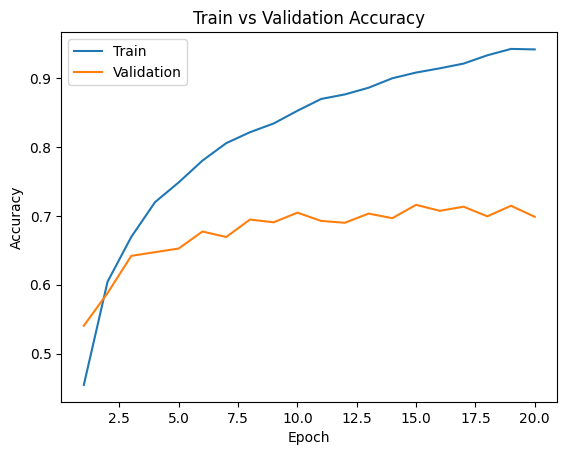

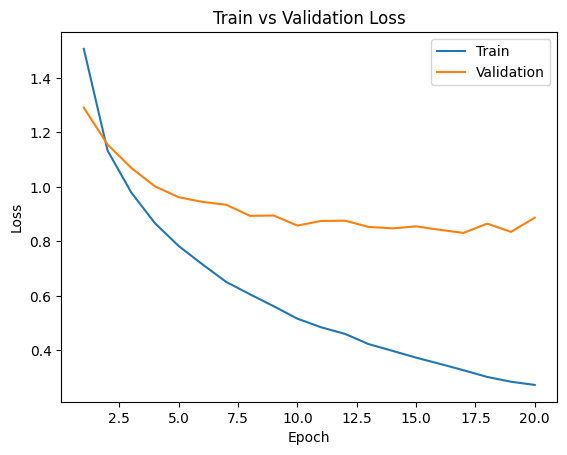

In [22]:
batch_size=32
learning_rate=0.00005
num_epochs=20

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.4551961064987117, Train loss: 1.5145206158811395 |Val acc: 0.539746158984636, Val loss: 1.2958869934082031
Epoch 2: Train acc: 0.6096478671628972, Train loss: 1.1384930003773082 |Val acc: 0.5791583166332666, Val loss: 1.1511723945538204
Epoch 3: Train acc: 0.6720584025193244, Train loss: 0.975632171197371 |Val acc: 0.603874415497662, Val loss: 1.0909263764818509
Epoch 4: Train acc: 0.7211565989121099, Train loss: 0.8571203307671981 |Val acc: 0.6018704074816299, Val loss: 1.0547902410229046
Epoch 5: Train acc: 0.7539364443172059, Train loss: 0.7741678920659152 |Val acc: 0.674682698730795, Val loss: 0.9718984936674436
Epoch 6: Train acc: 0.7799885485256226, Train loss: 0.7066370083527131 |Val acc: 0.6586506346025385, Val loss: 0.9537197550137838
Epoch 7: Train acc: 0.8044660750071572, Train loss: 0.650538286024874 |Val acc: 0.6887107548430194, Val loss: 0.9029040584961573
Epoch 8: Train acc: 0.8249355854566276, Train loss: 0.5964754199439829 |Val acc: 0.686706746826

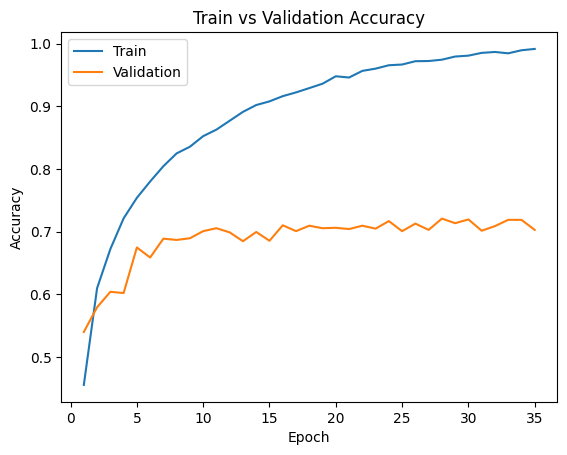

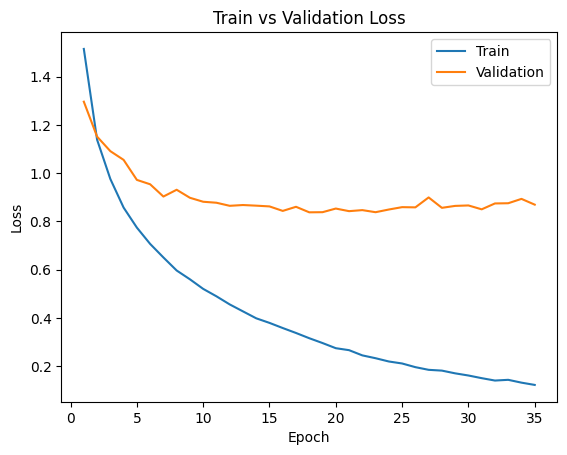

In [29]:
batch_size=64
learning_rate=0.00007
num_epochs=35

music_net_tf = MusicNetTF()
music_net_tf = music_net_tf.to(device)

train_tf(music_net_tf, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [8]:
class MusicNetTFDropout(nn.Module):
    def __init__(self):
        super(MusicNetTFDropout, self).__init__()
        self.name = "musicnet_tf_dropout"
        self.fc1 = nn.Linear(256*10*14, 250)
        self.fc2 = nn.Linear(250, 10)  # Output layer with 10 classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256*10*14)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

Epoch 1: Train acc: 0.38290867449184085, Train loss: 1.690400656786832 |Val acc: 0.45758183032732136, Val loss: 1.4799119681119919
Epoch 2: Train acc: 0.5084454623532779, Train loss: 1.3680423097176986 |Val acc: 0.5197060788243153, Val loss: 1.35105204085509
Epoch 3: Train acc: 0.5614085313484112, Train loss: 1.2298935212872244 |Val acc: 0.548430193720775, Val loss: 1.2634132007757823
Epoch 4: Train acc: 0.6002004008016032, Train loss: 1.1194621454585683 |Val acc: 0.5651302605210421, Val loss: 1.2443158775568008
Epoch 5: Train acc: 0.6397079874033782, Train loss: 1.0339360063726253 |Val acc: 0.5858383433533734, Val loss: 1.1615554864207904
Epoch 6: Train acc: 0.6683366733466933, Train loss: 0.9654690303585746 |Val acc: 0.612558450233801, Val loss: 1.1121048306425412
Epoch 7: Train acc: 0.6943887775551103, Train loss: 0.9028415040536361 |Val acc: 0.6012024048096192, Val loss: 1.0942669933040936
Epoch 8: Train acc: 0.7048382479244203, Train loss: 0.86104628497904 |Val acc: 0.630594522378

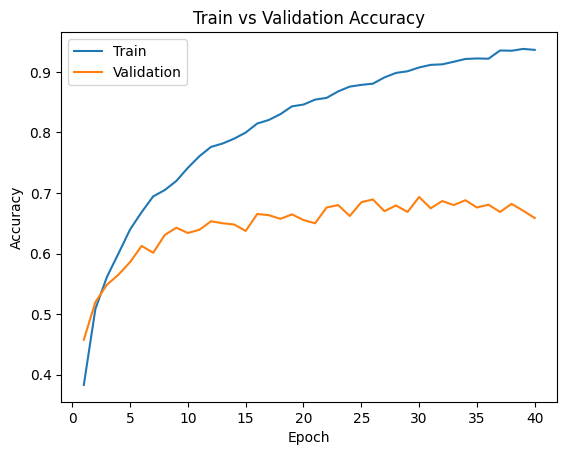

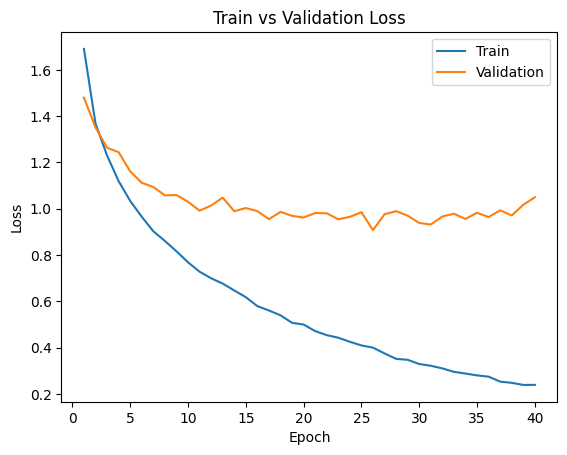

In [35]:
batch_size=64
learning_rate=0.00009
num_epochs=40

music_net_tf_drop = MusicNetTFDropout()
music_net_tf_drop = music_net_tf_drop.to(device)

train_tf(music_net_tf_drop, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.3960778700257658, Train loss: 1.6928599299905507 |Val acc: 0.4382097528390113, Val loss: 1.5214480567485729
Epoch 2: Train acc: 0.5065845977669625, Train loss: 1.3789191066402278 |Val acc: 0.5003340013360054, Val loss: 1.3743408563289237
Epoch 3: Train acc: 0.5575436587460636, Train loss: 1.239984087475903 |Val acc: 0.5357381429525718, Val loss: 1.2879112984271759
Epoch 4: Train acc: 0.5977669624964215, Train loss: 1.1402873448585267 |Val acc: 0.5457581830327322, Val loss: 1.2292833784793287
Epoch 5: Train acc: 0.6263956484397366, Train loss: 1.0629393823070614 |Val acc: 0.5724782899131596, Val loss: 1.1794880032539368
Epoch 6: Train acc: 0.6518751789292871, Train loss: 0.9895944593976077 |Val acc: 0.605878423513694, Val loss: 1.1409295974893774
Epoch 7: Train acc: 0.6835098768966504, Train loss: 0.9264161249273988 |Val acc: 0.6085504342017368, Val loss: 1.095991851167476
Epoch 8: Train acc: 0.7016890924706556, Train loss: 0.8818891179071714 |Val acc: 0.6185704742

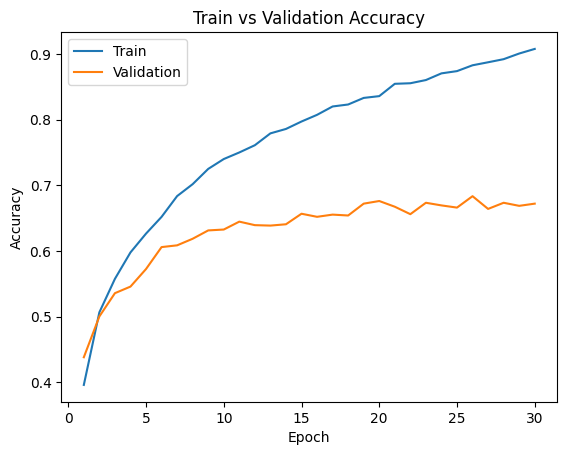

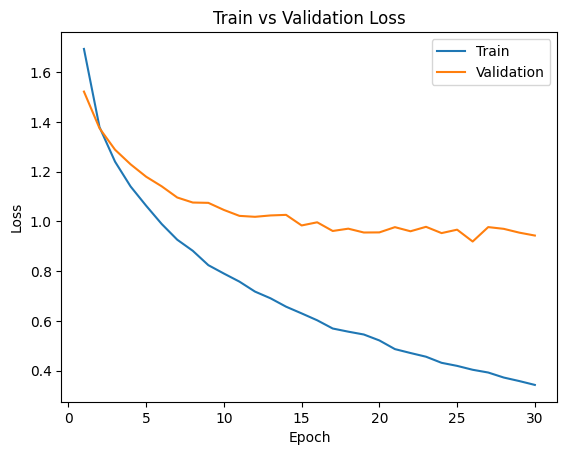

In [36]:
batch_size=32
learning_rate=0.00005
num_epochs=30

music_net_tf_drop = MusicNetTFDropout()
music_net_tf_drop = music_net_tf_drop.to(device)

train_tf(music_net_tf_drop, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet_tf_dropout", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [9]:
def retrieve_best_model(model_class, batch_size, lr, num_epochs):
    best_model = model_class()
    best_model = best_model.to(device)
    best_model_path = get_model_name(best_model.name, batch_size=batch_size, learning_rate=lr, epoch=num_epochs)
    best_model.load_state_dict(torch.load(best_model_path))
    return best_model

def testing(model_class, batch_size, lr, num_epochs, loader, criterion):
    # Load best model
    best_model = retrieve_best_model(model_class, batch_size, lr, num_epochs)

    # Evaluate
    test_acc, test_loss = evaluate_tf(best_model, loader, criterion)
    print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

In [12]:
batch_size=64
learning_rate=0.00007
num_epochs=35

criterion = nn.CrossEntropyLoss()
_, _, test_loader = get_dataloader(music_dataset, batch_size=batch_size)

testing(model_class=MusicNetTF,
        batch_size=batch_size,
        lr=learning_rate,
        num_epochs=num_epochs - 1,
        loader=test_loader,
        criterion=criterion
      )

Test accuracy: 0.6795727636849132 | Test loss: 0.9986847092707952


# Show confusion matrix

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(120.72222222222221, 0.5, 'Label')]

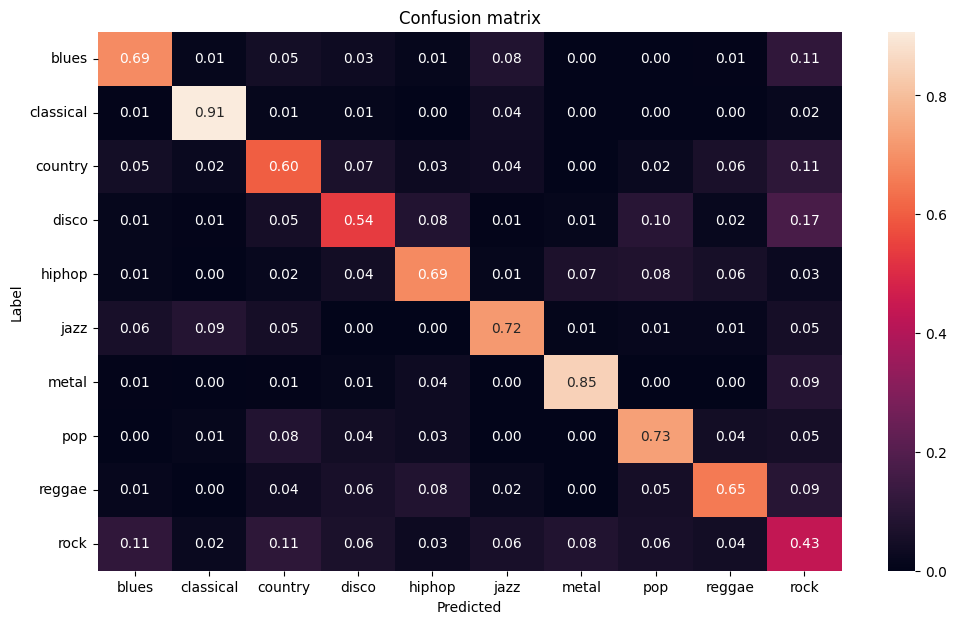

In [22]:
batch_size=64
learning_rate=0.00007
num_epochs=35
model_class = MusicNetTF

best_model = retrieve_best_model(model_class, batch_size, learning_rate, num_epochs-1)

y_pred = []
y_true = []
_, _, test_loader = get_dataloader(music_dataset, batch_size=batch_size)

# iterate over test data
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # Compute features with alexnet
    features = alexnet.features(inputs)
    
    output = best_model(features) # Feed Network
    pred = torch.argmax(output,1).cpu().numpy()
    y_pred.extend(pred) # Save Prediction
    
    labels = labels.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Confusion matrix")
axis = sn.heatmap(df_cm, annot=True, fmt=".2f")
axis.set(xlabel="Predicted", ylabel="Label")
# plt.savefig('output.png')

# Test best model on new data

In [12]:
eval_dataset = datasets.ImageFolder("./Evaluate2/", transform=transformer)

eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=1)

[Text(0.5, 47.7222222222222, 'Predicted'),
 Text(120.72222222222221, 0.5, 'Label')]

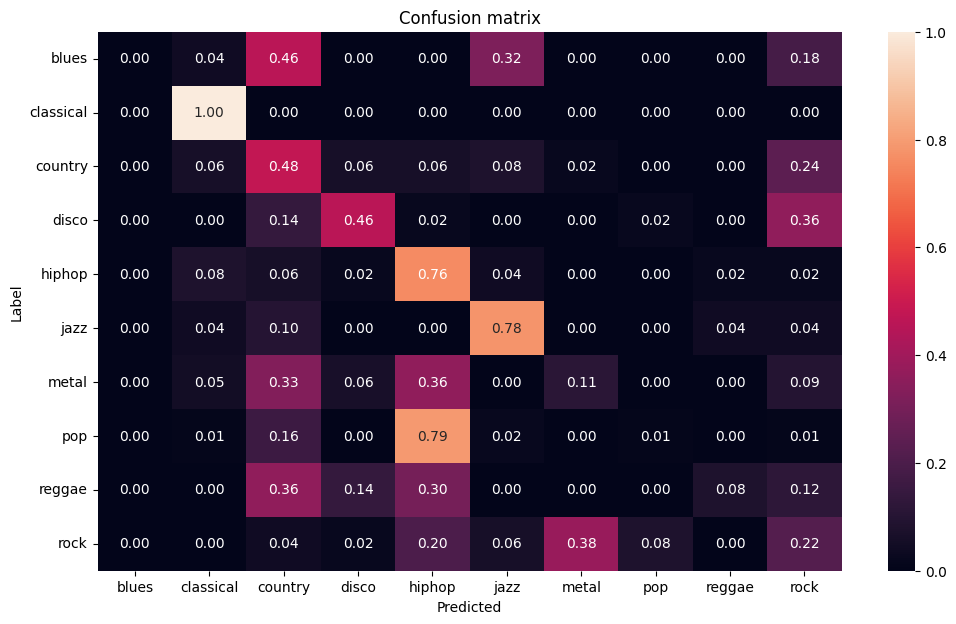

In [14]:
batch_size=64
learning_rate=0.00007
num_epochs=35
model_class = MusicNetTF

best_model = retrieve_best_model(model_class, batch_size, learning_rate, num_epochs-1)

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in eval_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # Compute features with alexnet
    features = alexnet.features(inputs)
    
    output = best_model(features) # Feed Network
    pred = torch.argmax(output,1).cpu().numpy()
    y_pred.extend(pred) # Save Prediction
    
    labels = labels.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
plt.title("Confusion matrix")
axis = sn.heatmap(df_cm, annot=True, fmt=".2f")
axis.set(xlabel="Predicted", ylabel="Label")

In [105]:
import PIL.Image as pil
from torchvision import transforms as tf

# constant for classes
classes = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

def index_to_class(idx):
    return classes[idx]

def evaluate_sample(path, transformer):
    img = np.array(pil.open(path))[:, :, :3]
    img = transformer(img)
    img = img.float().to(device)

    features = alexnet.features(img)
    out = best_model(features)
    pred = torch.argmax(out,1).cpu().numpy()[0]

    return index_to_class(pred)

In [118]:
transformer = tf.Compose([
        tf.ToTensor(),
        tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size=64
learning_rate=0.00007
num_epochs=35
model_class = MusicNetTF

best_model = retrieve_best_model(model_class, batch_size, learning_rate, num_epochs-1)

thunderstruck_extract_path = "./Evaluate2/rock/Thunderstruck_segment_52.png"
thunderstruck_pred = evaluate_sample(thunderstruck_extract_path, transformer=transformer)

other_thunderstruck_extract_path = "./Evaluate2/rock/Thunderstruck_segment_50.png"
other_thunderstruck_pred = evaluate_sample(other_thunderstruck_extract_path, transformer=transformer)

another_thunderstruck_extract_path = "./Evaluate2/rock/Thunderstruck_segment_64.png"
another_thunderstruck_pred = evaluate_sample(another_thunderstruck_extract_path, transformer=transformer)

print("----- Thunderstruck - AC/DC extract -----")
print(f"  Predicted genre: {thunderstruck_pred}")
print(f"  True genre:      rock\n")

print("----- Other Thunderstruck - AC/DC extract -----")
print(f"  Predicted genre: {other_thunderstruck_pred}")
print(f"  True genre:      rock\n")

print("----- Another Thunderstruck - AC/DC extract -----")
print(f"  Predicted genre: {another_thunderstruck_pred}")
print(f"  True genre:      rock\n")

classical_extract_path = "./Evaluate2/classical/The 4 Seasons, Op. 8-4, RV 297, Winter_segment_50.png"
classical_pred = evaluate_sample(classical_extract_path, transformer=transformer)

other_classical_extract_path = "./Evaluate2/classical/The 4 Seasons, Op. 8-4, RV 297, Winter_segment_60.png"
other_classical_pred = evaluate_sample(other_classical_extract_path, transformer=transformer)

another_classical_extract_path = "./Evaluate2/classical/The 4 Seasons, Op. 8-4, RV 297, Winter_segment_73.png"
another_classical_pred = evaluate_sample(another_classical_extract_path, transformer=transformer)

print("----- The 4 Seasons, Op. 8-4, RV 297, Winter extract -----")
print(f"  Predicted genre: {classical_pred}")
print(f"  True genre:      classical\n")

print("----- Other The 4 Seasons, Op. 8-4, RV 297, Winter extract -----")
print(f"  Predicted genre: {other_classical_pred}")
print(f"  True genre:      classical\n")

print("----- Another The 4 Seasons, Op. 8-4, RV 297, Winter extract -----")
print(f"  Predicted genre: {another_classical_pred}")
print(f"  True genre:      classical\n")

----- Thunderstruck - AC/DC extract -----
  Predicted genre: rock
  True genre:      rock

----- Other Thunderstruck - AC/DC extract -----
  Predicted genre: country
  True genre:      rock

----- Another Thunderstruck - AC/DC extract -----
  Predicted genre: metal
  True genre:      rock

----- The 4 Seasons, Op. 8-4, RV 297, Winter extract -----
  Predicted genre: classical
  True genre:      classical

----- Other The 4 Seasons, Op. 8-4, RV 297, Winter extract -----
  Predicted genre: classical
  True genre:      classical

----- Another The 4 Seasons, Op. 8-4, RV 297, Winter extract -----
  Predicted genre: classical
  True genre:      classical

